# Basic experiment

# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)


In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<Axes: >

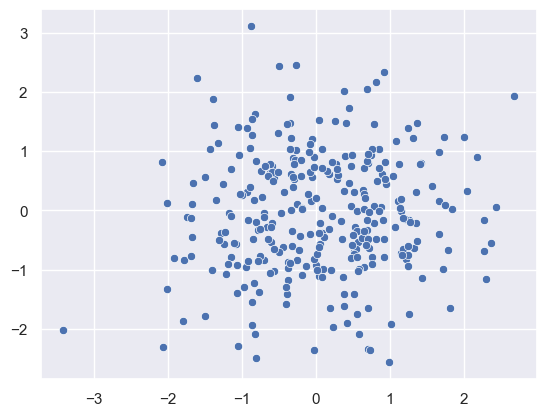

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

<Axes: >

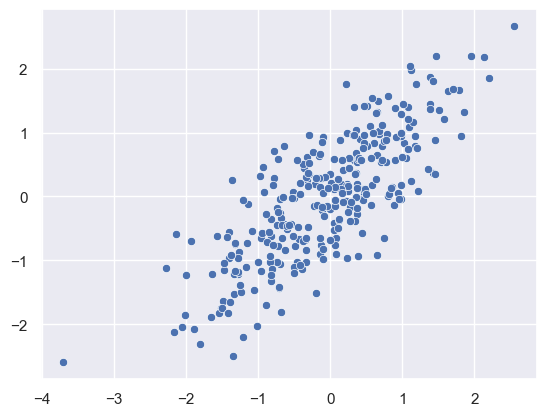

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [9]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [ ]:
def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

<Axes: >

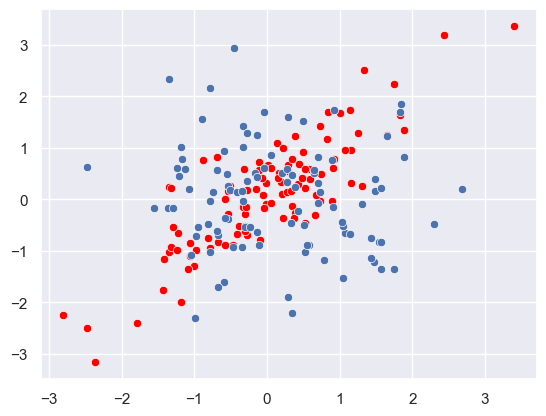

In [14]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [46]:
joint_data = sample_batch(x,batch_size=100,sample_mode='joint')
marginal_data = sample_batch(x,batch_size=100,sample_mode='marginal')


(300, 4)
(100, 4)


In [47]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(5e+3), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        # print(batch[0].shape, batch[1].shape)
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [16]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [48]:
mine_net_indep = Mine(input_size=x.shape[1]).cuda()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-3)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

(300, 4)
(100, 4)
(100, 4) (100, 2)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 4x100)

-5.4218663e-06


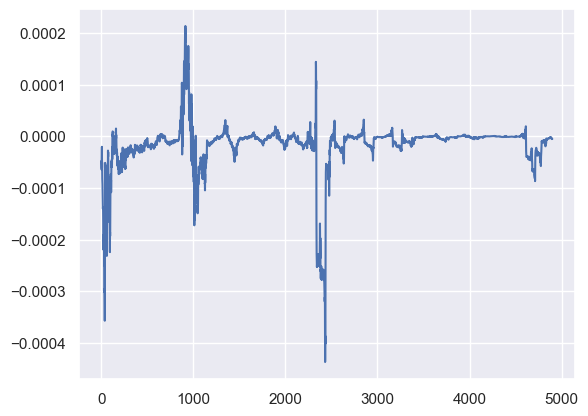

In [15]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [16]:
mine_net_cor = Mine().cuda()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.43871257
0.73709315
0.5963839
0.5140882
0.62733185


0.55475926


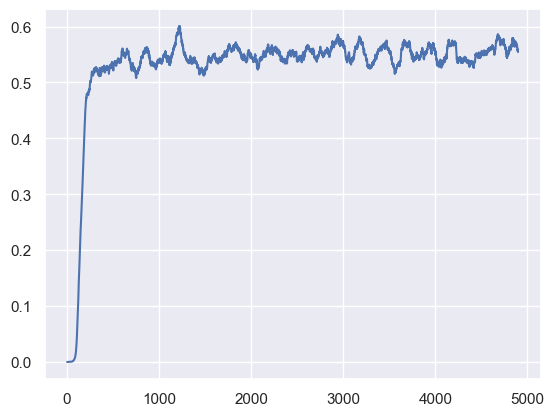

In [17]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [18]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


0.8218872
0.7833964
0.7152627
0.66930735
1.0065683
-0.9 : 0.9580456
0.54955137
0.29476312
0.5913655
0.6365337
0.38067517
-0.8 : 0.4846191
0.26738563
0.15232995
0.2236997
0.32591072
0.22936112
-0.7 : 0.31000555
0.33736977
0.14369842
0.17704742
0.19388501
0.32094625
-0.6 : 0.22088282
0.15036106
0.13677296
0.20268154
0.14302623
0.19971177
-0.5 : 0.14044161
0.12075566
0.11345535
0.20858356
0.16160753
0.11620292
-0.4 : 0.12601806
-0.010340637
-0.042473238
0.032113746
0.06407347
0.041425757
-0.29999999999999993 : 0.04813475
-6.2100575e-05
-2.072574e-05
0.00071551604
0.0061065704
0.003836454
-0.19999999999999996 : 0.0052854484
-0.00013298911
-0.0038910871
-0.005217775
0.005139473
0.006764142
-0.09999999999999998 : 0.00851246
1.4888283e-06
2.078485e-05
-0.0003631726
-4.619593e-06
-7.5127464e-05
0.0 : 1.9362599e-06
-0.00013056492
-4.0744257e-05
-5.3294934e-06
-1.618464e-06
-0.00042317493
0.09999999999999998 : 1.4187177e-05
-0.0009919407
0.01843608
0.011063125
-0.012622882
-0.008004868
0.2000000

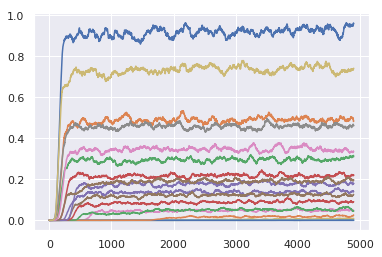

In [19]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine().cuda()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

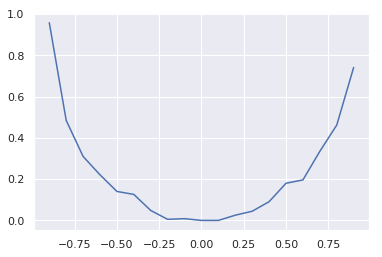

In [20]:
plt.plot(correlations, final_result)

# Equitability experiment

Check more information at [original equitability paper](http://www.pnas.org/content/pnas/111/9/3354.full.pdf).

# Make toy data

In [21]:
x = np.random.uniform(low=-1.,high=1.,size=3000)
f1 = x
f2 = 2*x
f3 = np.sin(x)
f4 = x**3
eps = np.random.normal(size=3000)

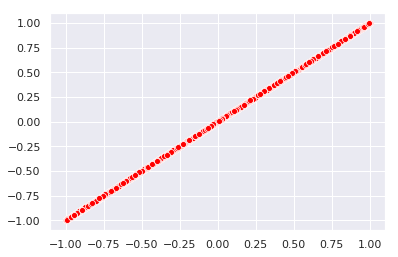

In [22]:
sns.scatterplot(x, f1,color='red')

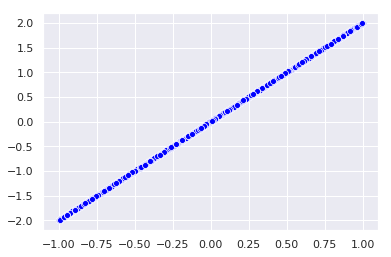

In [23]:
sns.scatterplot(x, f2,color='blue')

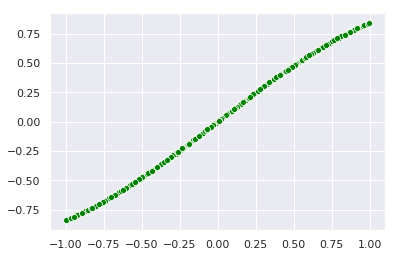

In [24]:
sns.scatterplot(x, f3,color='green')

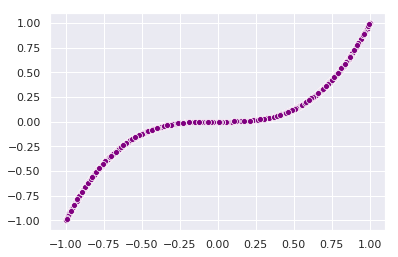

In [25]:
sns.scatterplot(x, f4,color='purple')

In [26]:
sigmas = np.linspace(0.0,0.9,10)
fs = [f1, f2, f3, f4]
print(sigmas)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


4.3165164
4.428666
4.693854
11.412927
5.0883727
0.0,0 : 5.773359
3.4128466
3.8177392
4.4555326
4.4452915
3.489471
0.0,1 : 5.864722
2.55121
2.4870567
3.3649533
2.5808315
3.5454357
0.0,2 : 3.0371892
1.0605474
1.0484655
1.8002052
1.7783278
2.7316294
0.0,3 : 1.8558613
1.6044647
1.7972416
1.6301302
1.2586992
1.9363227
0.1,0 : 1.6577556
2.5292113
3.4724848
2.9540653
2.444877
2.1020966
0.1,1 : 2.363647
1.2385798
1.5869575
1.392125
1.4103067
1.3495559
0.1,2 : 1.5508937
1.137523
0.7532096
0.82436013
0.9533508
1.2207271
0.1,3 : 1.0978585
0.9161378
0.93390846
0.85513234
0.88875747
0.9204679
0.2,0 : 1.0572222
1.4972677
1.6500105
1.563633
2.1706228
1.9646666
0.2,1 : 1.6792473
0.9622601
0.7099171
0.88597417
0.9166153
0.9260552
0.2,2 : 0.97315335
0.21291333
0.5130028
0.7539356
0.45293054
0.72957635
0.2,3 : 0.5490277
0.7204771
0.7493786
0.85244
0.74890107
0.9470168
0.30000000000000004,0 : 0.74223465
1.3280952
0.85781586
1.6996737
1.5334388
1.4874064
0.30000000000000004,1 : 1.3006543
0.56149685
0.79391

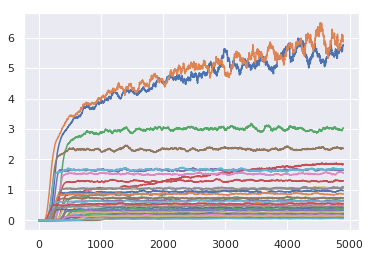

In [27]:
final_result = []
for sigma in sigmas:
    for fi, f in enumerate(fs):
        data = np.concatenate([x.reshape(-1,1), (f + sigma * eps).reshape(-1,1)], axis=1)
        mine_net = Mine().cuda()
        mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)
        result = train(data,mine_net,mine_net_optim,iter_num=int(5e+3))
        result_ma = ma(result)
        final_result.append(result_ma[-1])
        print(str(sigma) + ',' + str(fi) +' : ' + str(final_result[-1]))
        plt.plot(range(len(result_ma)),result_ma)

In [28]:
re_final_result = np.transpose(np.array([final_result[4*i: 4*i+4]  for i in range(10)]))
print(re_final_result)

[[5.773359   1.6577556  1.0572222  0.74223465 0.5394236  0.41392532
  0.324629   0.2505124  0.19948366 0.15108423]
 [5.864722   2.363647   1.6792473  1.3006543  1.0629547  0.87138265
  0.7165672  0.6171741  0.5421426  0.46416825]
 [3.0371892  1.5508937  0.97315335 0.6528235  0.49730837 0.37166065
  0.27176207 0.22408777 0.16892713 0.15220916]
 [1.8558613  1.0978585  0.5490277  0.3773468  0.2407205  0.18949112
  0.14217764 0.10066611 0.08995808 0.06090287]]


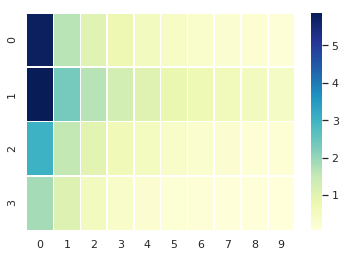

In [29]:
sns.heatmap(re_final_result,cmap="YlGnBu",linewidths=.5)